# Gráficas de Resultados
Este cuaderno carga resultados de `resultados/*/*.json` y el CSV `Tiempos para las instancias.csv` para generar gráficas comparativas de distancia y tiempo para ACO, Genético y, cuando exista, GAMS.

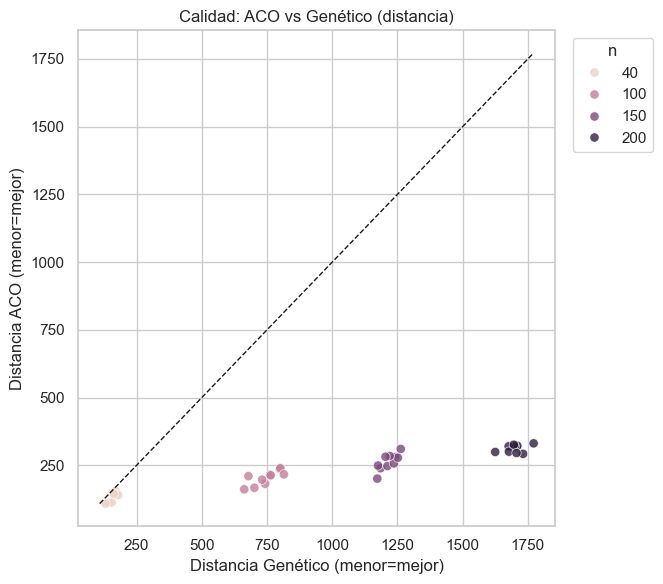

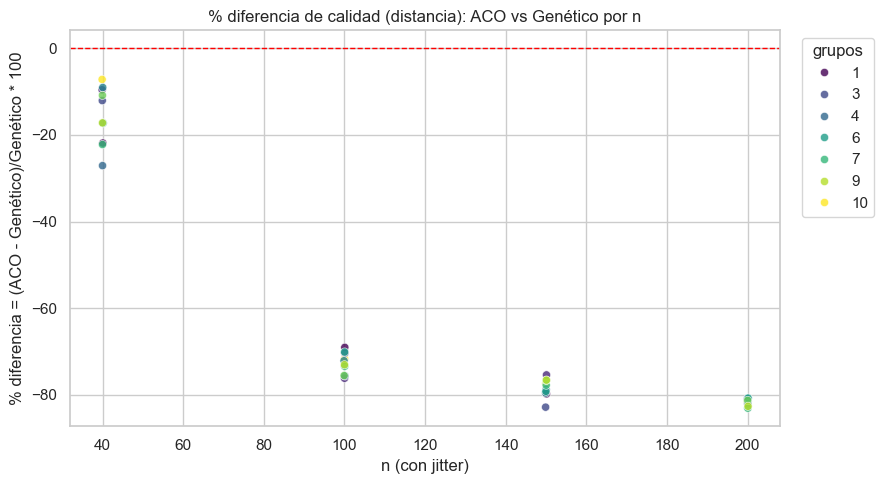

In [33]:
# Scatter de diferencia en calidad de solución (distancia)
# - Gráfico 1: distancia Genético vs distancia ACO (línea y=x como referencia)
# - Gráfico 2: % diferencia (ACO vs Genético) por tamaño n (jitter)
import numpy as np
cols_need = ['instancia','grupos','n','distancia_aco','distancia_genetico']
df_plot = pivot[cols_need].dropna(subset=['distancia_aco','distancia_genetico']).copy()
if df_plot.empty:
    print('No hay datos suficientes para el scatter de calidad (distancias).')
else:
    # Métricas de diferencia
    df_plot['diff_abs'] = df_plot['distancia_aco'] - df_plot['distancia_genetico']
    df_plot['diff_pct'] = (df_plot['distancia_aco'] - df_plot['distancia_genetico']) / df_plot['distancia_genetico'] * 100
    # Scatter 1: ACO vs Genético
    plt.figure(figsize=(6.8,6.0))
    if sns is not None:
        sns.scatterplot(data=df_plot, x='distancia_genetico', y='distancia_aco', hue='n', alpha=0.8, s=45)
        plt.legend(title='n', bbox_to_anchor=(1.02, 1), loc='upper left')
    else:
        for nval, dsub in df_plot.groupby('n'):
            plt.scatter(dsub['distancia_genetico'], dsub['distancia_aco'], alpha=0.8, s=45, label=f'n={nval}')
        plt.legend(title='n', bbox_to_anchor=(1.02, 1), loc='upper left')
    mn = float(min(df_plot['distancia_genetico'].min(), df_plot['distancia_aco'].min()))
    mx = float(max(df_plot['distancia_genetico'].max(), df_plot['distancia_aco'].max()))
    plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
    plt.xlabel('Distancia Genético (menor=mejor)')
    plt.ylabel('Distancia ACO (menor=mejor)')
    plt.title('Calidad: ACO vs Genético (distancia)')
    plt.tight_layout()
    plt.savefig(DIR_OUT / 'scatter_calidad_aco_vs_genetico.png', dpi=160)
    plt.show()

    # Scatter 2: % diferencia por n (ACO vs Genético)
    rng = np.random.default_rng(0)
    df_plot['n_jitter'] = df_plot['n'] + rng.uniform(-0.12, 0.12, size=len(df_plot))
    plt.figure(figsize=(9,5))
    if sns is not None:
        sns.scatterplot(data=df_plot, x='n_jitter', y='diff_pct', hue='grupos', palette='viridis', alpha=0.8, s=35)
        plt.legend(title='grupos', bbox_to_anchor=(1.02, 1), loc='upper left')
    else:
        for grp, dsub in df_plot.groupby('grupos'):
            plt.scatter(dsub['n_jitter'], dsub['diff_pct'], alpha=0.8, s=35, label=f'g={grp}')
        plt.legend(title='grupos', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('n (con jitter)')
    plt.ylabel('% diferencia = (ACO - Genético)/Genético * 100')
    plt.title('% diferencia de calidad (distancia): ACO vs Genético por n')
    plt.tight_layout()
    plt.savefig(DIR_OUT / 'scatter_dif_pct_por_n.png', dpi=160)
    plt.show()


In [34]:
from pathlib import Path
import json
import math
import sys, subprocess

def ensure_packages(pkgs):
    missing = []
    loaded = {}
    for pkg in pkgs:
        try:
            loaded[pkg] = __import__(pkg)
        except Exception:
            missing.append(pkg)
    if missing:
        print('Instalando paquetes faltantes con pip:', ', '.join(missing))
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
        except Exception as e:
            print('No se pudieron instalar automáticamente:', missing, e)
            print('Instálalos manualmente con: pip install', ' '.join(missing))
    # Reimportar los que faltaban
    import importlib
    for pkg in missing:
        try:
            loaded[pkg] = importlib.import_module(pkg)
        except Exception:
            pass
    # Devolver módulos cargados y lista final de faltantes
    still_missing = [p for p in pkgs if p not in loaded]
    return loaded, still_missing

mods, still_missing = ensure_packages(['pandas','matplotlib','seaborn'])
import importlib as _importlib
pd = mods.get('pandas') or _importlib.import_module('pandas')
# Importar explícitamente pyplot para evitar colisiones con matplotlib.figure
try:
    plt = _importlib.import_module('matplotlib.pyplot')
except Exception:
    import matplotlib as _mpl
    plt = _mpl
try:
    sns = mods.get('seaborn') or _importlib.import_module('seaborn')
except Exception:
    sns = None
if sns is None:
    print('Aviso: seaborn no disponible. Usaré matplotlib; las gráficas serán más simples.')
    try:
        import matplotlib as _mpl
        _mpl.style.use('ggplot')
    except Exception:
        pass
else:
    sns.set(style='whitegrid')
BASE = Path('.')
DIR_RES = BASE / 'resultados'
CSV_TIEMPOS = BASE / 'Tiempos para las instancias.csv'
DIR_OUT = BASE / 'graficas'
DIR_OUT.mkdir(exist_ok=True)


In [35]:
def parse_instancia_name(name:str):
    try:
        a,b = name.split('_')
        return int(a), int(b)
    except Exception:
        return None, None

def load_json_results(dir_res:Path=DIR_RES):
    rows = []
    for json_path in sorted(dir_res.glob('*/*.json')):
        instancia = json_path.stem  # '10_100'
        grupos, n = parse_instancia_name(instancia)
        try:
            data = json.loads(json_path.read_text(encoding='utf-8'))
        except Exception as e:
            print(f"No se pudo leer {json_path}: {e}")
            continue
        for alg in ('genetico','aco'):
            if alg in data:
                d = data[alg]
                distancia = d.get('distancia', None)
                tiempo = d.get('tiempo', None)
                rows.append({
                    'instancia': instancia,
                    'grupos': grupos,
                    'n': n,
                    'algoritmo': alg,
                    'distancia': distancia,
                    'tiempo': tiempo,
                })
    df = pd.DataFrame(rows)
    # Orden consistente
    if not df.empty:
        df = df.sort_values(['n','grupos','algoritmo']).reset_index(drop=True)
    return df

df_res = load_json_results()
print(f"Instancias en JSON: {df_res['instancia'].nunique() if not df_res.empty else 0}")
df_res.head()


Instancias en JSON: 40


,instancia,grupos,n,algoritmo,distancia,tiempo
0,1_40,1,40,aco,112.345831,33.769169
1,1_40,1,40,genetico,143.789111,1.299857
2,2_40,2,40,aco,153.719654,31.671080
3,2_40,2,40,genetico,169.981956,1.189792
4,3_40,3,40,aco,142.938675,31.408782


In [36]:
def load_csv_tiempos(path:Path=CSV_TIEMPOS):
    if not path.exists():
        return pd.DataFrame()
    df = pd.read_csv(path)
    # Normalizar encabezados
    cols = {c:c.strip() for c in df.columns}
    df = df.rename(columns=cols)
    rename = {
        'Instancia': 'instancia',
        'Instancia ': 'instancia',
        'Tiempo en gams': 'tiempo_gams',
        'Valor optimo en gams': 'valor_gams',
        'Valor optimo en gams ': 'valor_gams',
        'Tiempo Algoritmo genetico': 'tiempo_genetico',
        'Valor  Genetico': 'valor_genetico',
        'Tiempo ACO': 'tiempo_aco',
        'Valor ACO': 'valor_aco',
    }
    for k,v in rename.items():
        if k in df.columns:
            df = df.rename(columns={k:v})
    # Quitar posibles espacios en instancia
    if 'instancia' in df.columns:
        df['instancia'] = df['instancia'].astype(str).str.strip()
        df[['grupos','n']] = df['instancia'].str.split('_', n=1, expand=True)
        with pd.option_context('mode.use_inf_as_na', True):
            df['grupos'] = pd.to_numeric(df['grupos'], errors='coerce').astype('Int64')
            df['n'] = pd.to_numeric(df['n'], errors='coerce').astype('Int64')
    return df

df_csv = load_csv_tiempos()
print(f"Filas en CSV: {len(df_csv)}")
missing_match = set(df_csv['instancia']) - set(df_res['instancia']) if not df_csv.empty and not df_res.empty else set()
if missing_match:
    print('Advertencia: instancias en CSV sin JSON correspondiente:', sorted(list(missing_match))[:10], '...')
df_csv.head()


Filas en CSV: 40
Advertencia: instancias en CSV sin JSON correspondiente: ['6_160'] ...


,instancia,tiempo_gams,valor_gams,tiempo_genetico,valor_genetico,tiempo_aco,valor_aco,grupos,n
0,1_40,19.839,110.4,2.413607,130.694720,65.270749,112.362968,1,40
1,2_40,24.495,146.7,2.560993,158.059277,64.296391,152.744744,2,40
2,3_40,1.977,142.0,2.320510,161.209752,63.355181,143.815686,3,40
3,4_40,21.347,111.9,2.335597,141.483601,69.353550,112.670847,4,40
4,5_40,3.423,150.0,2.452739,178.779827,67.306587,156.387427,5,40


In [37]:
# Preparar DataFrames para gráficas unificadas
if df_res.empty:
    raise RuntimeError('No se encontraron resultados JSON en la carpeta resultados/*/*.json')

# Derivar dataset long para distancia y tiempo
df_long = df_res.copy()

# Incorporar valores de GAMS si están en CSV
if not df_csv.empty and {'valor_gams','tiempo_gams','instancia'}.issubset(df_csv.columns):
    gcols = ['instancia','valor_gams','tiempo_gams']
    gams = df_csv[gcols].drop_duplicates('instancia')
    df_long = df_long.merge(gams, on='instancia', how='left')

df_long.head()


,instancia,grupos,n,algoritmo,distancia,tiempo,valor_gams,tiempo_gams
0,1_40,1,40,aco,112.345831,33.769169,110.4,19.839
1,1_40,1,40,genetico,143.789111,1.299857,110.4,19.839
2,2_40,2,40,aco,153.719654,31.671080,146.7,24.495
3,2_40,2,40,genetico,169.981956,1.189792,146.7,24.495
4,3_40,3,40,aco,142.938675,31.408782,142.0,1.977


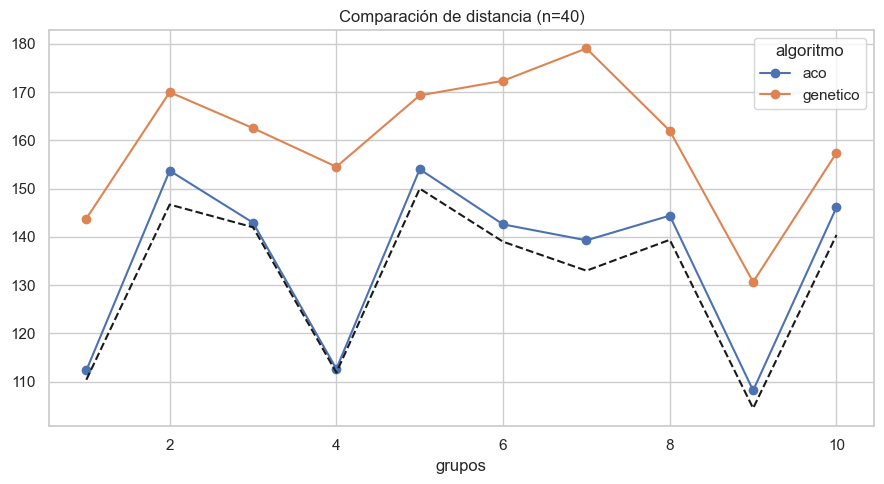

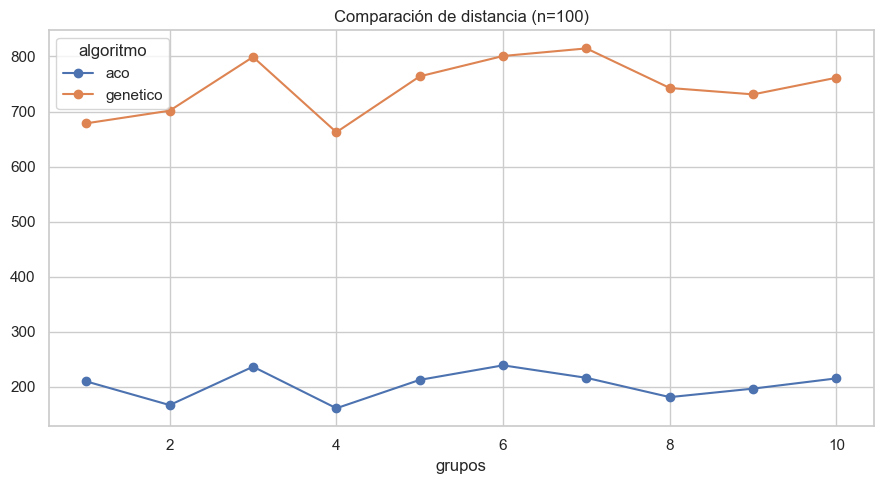

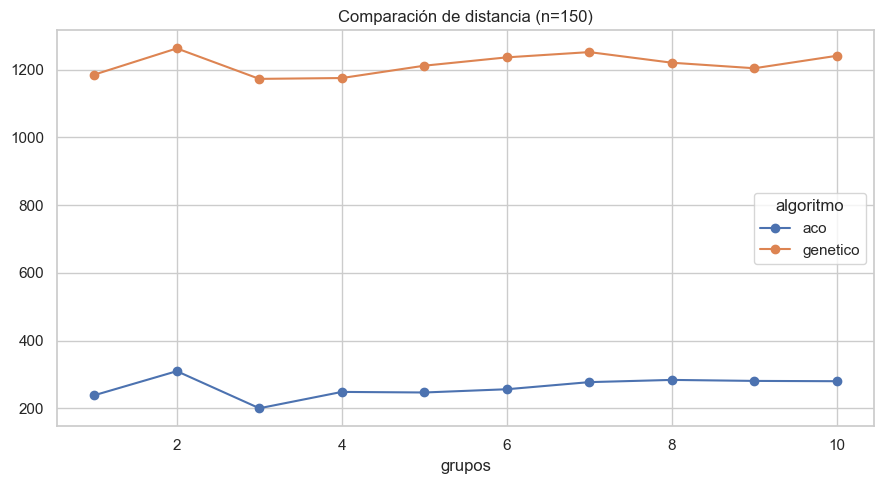

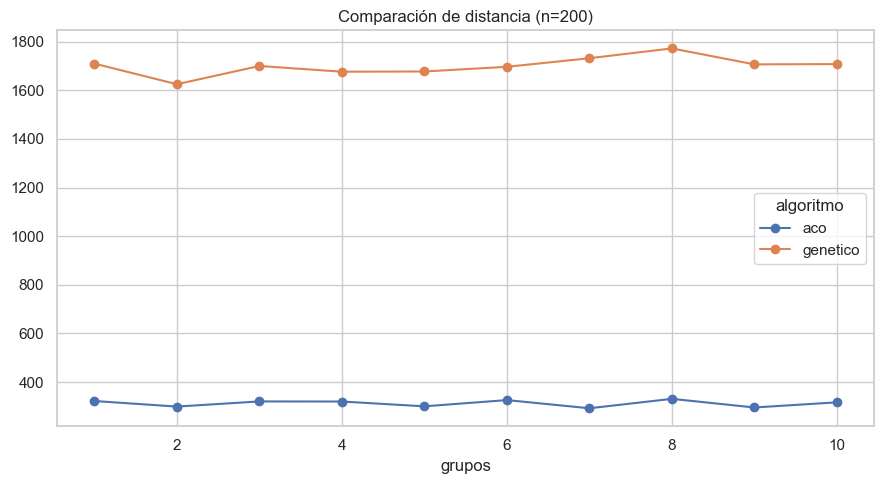

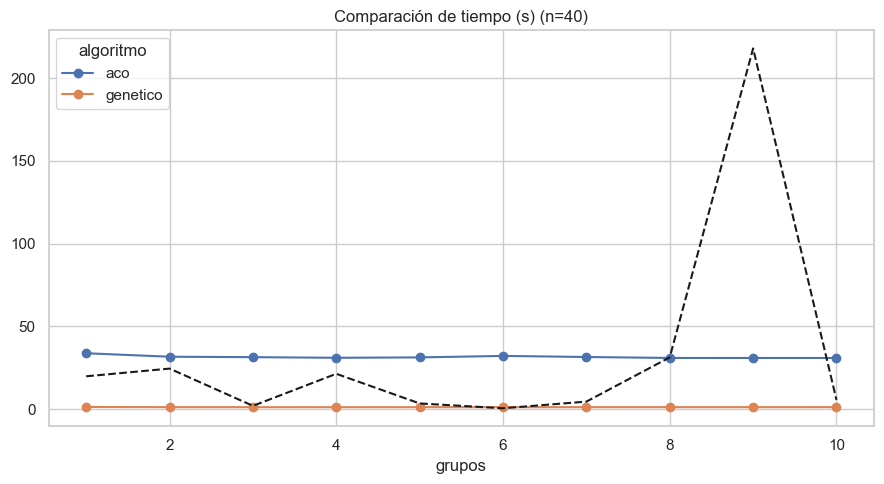

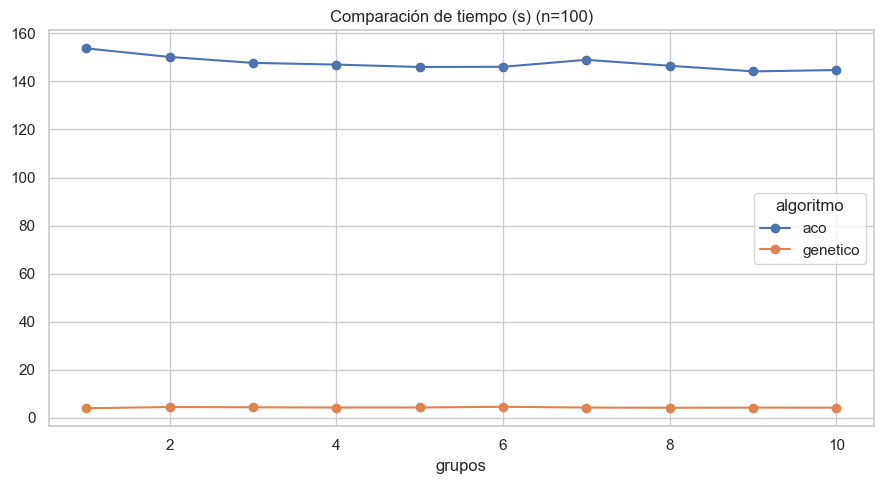

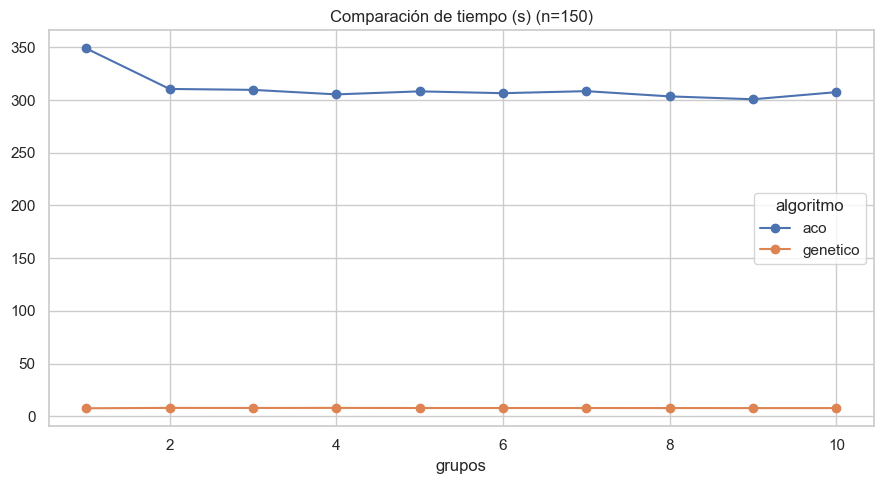

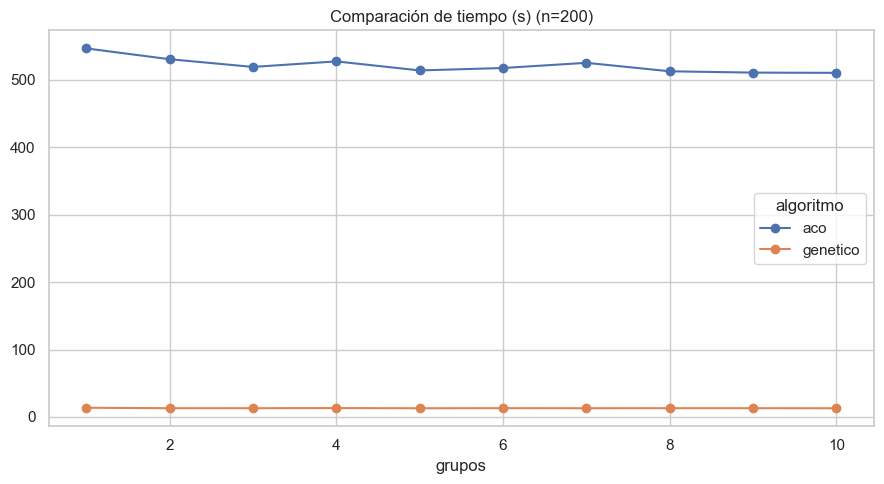

In [38]:
def plot_metric(df, metric:str, title:str, fname_prefix:str):
    # Facet por n (tamaño de instancia)
    # Asegurar tipos numéricos básicos
    dft = df.copy()
    dft['grupos'] = pd.to_numeric(dft['grupos'], errors='coerce')
    if metric in dft.columns:
        dft[metric] = pd.to_numeric(dft[metric], errors='coerce')
    ns = sorted(pd.Series(dft['n']).dropna().unique())
    if not ns:
        ns = [None]
    for nval in ns:
        dff = dft if nval is None else dft[dft['n'] == nval]
        if dff.empty:
            continue
        plt.figure(figsize=(9,5))
        # Trazado robusto: pivot para asegurar alineación por grupos
        wide = dff.pivot_table(index='grupos', columns='algoritmo', values=metric, aggfunc='first').sort_index()
        if sns is not None:
            for alg in wide.columns:
                plt.plot(wide.index, wide[alg], marker='o', label=str(alg))
            plt.legend(title='algoritmo')
        else:
            for alg in wide.columns:
                plt.plot(wide.index, wide[alg], marker='o', label=str(alg))
            plt.legend(title='algoritmo')
        # Agregar línea GAMS si existe
        if f'valor_gams' in dff.columns and metric == 'distancia':
            # Hay un valor por instancia; graficamos como puntos/linea negra
            gplot = dff.drop_duplicates(['instancia'])
            if not gplot['valor_gams'].isna().all():
                gplot = gplot.sort_values('grupos')
                plt.plot(gplot['grupos'], gplot['valor_gams'], 'k--', label='gams')
        if f'tiempo_gams' in dff.columns and metric == 'tiempo':
            gplot = dff.drop_duplicates(['instancia'])
            if not gplot['tiempo_gams'].isna().all():
                gplot = gplot.sort_values('grupos')
                plt.plot(gplot['grupos'], gplot['tiempo_gams'], 'k--', label='gams')
        ttl = title + (f' (n={nval})' if nval is not None else '')
        plt.title(ttl)
        plt.xlabel('grupos')
        plt.tight_layout()
        out = DIR_OUT / f"{fname_prefix}_n{nval if nval is not None else 'NA'}.png"
        plt.savefig(out, dpi=160)
        plt.show()

plot_metric(df_long, 'distancia', 'Comparación de distancia', 'distancia')
plot_metric(df_long, 'tiempo', 'Comparación de tiempo (s)', 'tiempo')


In [39]:
# Resumen comparativo
pivot = (df_res.pivot_table(index=['instancia','grupos','n'], columns='algoritmo', values=['distancia','tiempo']))
pivot.columns = [f"{a}_{b}" for a,b in pivot.columns]
pivot = pivot.reset_index()
if {'distancia_aco','distancia_genetico'}.issubset(pivot.columns):
    pivot['distancia_aco_mejor'] = pivot['distancia_aco'] < pivot['distancia_genetico']
    print('ACO mejor distancia en', int(pivot['distancia_aco_mejor'].sum()), 'de', len(pivot), 'instancias')
if {'tiempo_aco','tiempo_genetico'}.issubset(pivot.columns):
    pivot['aco_mas_lento'] = pivot['tiempo_aco'] > pivot['tiempo_genetico']
    print('ACO más lento que Genético en', int(pivot['aco_mas_lento'].sum()), 'de', len(pivot), 'instancias')
pivot.head()


ACO mejor distancia en 40 de 40 instancias
ACO más lento que Genético en 40 de 40 instancias


,instancia,grupos,n,distancia_aco,distancia_genetico,tiempo_aco,tiempo_genetico,distancia_aco_mejor,aco_mas_lento
0,10_100,10,100,215.345145,761.489746,144.763745,4.147204,True,True
1,10_150,10,150,280.384424,1240.976187,307.510575,7.865000,True,True
2,10_200,10,200,316.479352,1707.626868,510.356601,12.916072,True,True
3,10_40,10,40,146.116337,157.403544,30.898948,1.199594,True,True
4,1_100,1,100,209.809871,678.615050,153.772170,3.899168,True,True


## Explicación
Este cuaderno: (1) carga resultados de `ACO` y `Genético` desde JSON por instancia, (2) integra tiempos/óptimos de GAMS si están en el CSV, (3) grafica distancia y tiempo por tamaño `n`, y (4) calcula resúmenes: ganador por instancia y % de mejora relativa.\n\n
Definiciones principales:\n
- Distancia: menor es mejor.\n
- Tiempo: menor es mejor.\n
- % mejora ACO vs Genético (distancia): `(dist_genético - dist_ACO) / dist_genético * 100`. Positivo implica que ACO mejora (menor distancia).\n
- % mejora ACO vs Genético (tiempo): `(tiempo_genético - tiempo_ACO) / tiempo_genético * 100`. Positivo implica que ACO es más rápido.

In [40]:
# Cálculo de mejoras y rankings
from IPython.display import display
df_imp = pivot.copy()
# Columnas de mejora relativa (positiva = ACO mejor)
if {'distancia_aco','distancia_genetico'}.issubset(df_imp.columns):
    df_imp['mejora_dist_aco_vs_genetico_pct'] = (df_imp['distancia_genetico'] - df_imp['distancia_aco']) / df_imp['distancia_genetico'] * 100
    df_imp['ganador_distancia'] = df_imp.apply(lambda r: 'aco' if r['distancia_aco'] < r['distancia_genetico'] else ('genetico' if r['distancia_genetico'] < r['distancia_aco'] else 'empate'), axis=1)
else:
    df_imp['mejora_dist_aco_vs_genetico_pct'] = float('nan')
    df_imp['ganador_distancia'] = 'NA'

if {'tiempo_aco','tiempo_genetico'}.issubset(df_imp.columns):
    df_imp['mejora_tiempo_aco_vs_genetico_pct'] = (df_imp['tiempo_genetico'] - df_imp['tiempo_aco']) / df_imp['tiempo_genetico'] * 100
    df_imp['ganador_tiempo'] = df_imp.apply(lambda r: 'aco' if r['tiempo_aco'] < r['tiempo_genetico'] else ('genetico' if r['tiempo_genetico'] < r['tiempo_aco'] else 'empate'), axis=1)
else:
    df_imp['mejora_tiempo_aco_vs_genetico_pct'] = float('nan')
    df_imp['ganador_tiempo'] = 'NA'

# Rankings de ganador (conteos)
table_ganadores_dist_overall = df_imp['ganador_distancia'].value_counts().rename('conteo').to_frame()
table_ganadores_dist_por_n = df_imp.groupby('n')['ganador_distancia'].value_counts().unstack(fill_value=0).sort_index()
table_ganadores_time_overall = df_imp['ganador_tiempo'].value_counts().rename('conteo').to_frame()
table_ganadores_time_por_n = df_imp.groupby('n')['ganador_tiempo'].value_counts().unstack(fill_value=0).sort_index()

# Top/bottom instancias por mejora de ACO
cols_dist = ['instancia','grupos','n','distancia_aco','distancia_genetico','mejora_dist_aco_vs_genetico_pct']
cols_time = ['instancia','grupos','n','tiempo_aco','tiempo_genetico','mejora_tiempo_aco_vs_genetico_pct']
top_mejora_dist = df_imp.sort_values('mejora_dist_aco_vs_genetico_pct', ascending=False)[cols_dist].head(10)
peor_dist = df_imp.sort_values('mejora_dist_aco_vs_genetico_pct', ascending=True)[cols_dist].head(10)
top_mejora_time = df_imp.sort_values('mejora_tiempo_aco_vs_genetico_pct', ascending=False)[cols_time].head(10)
peor_time = df_imp.sort_values('mejora_tiempo_aco_vs_genetico_pct', ascending=True)[cols_time].head(10)

print('Ganadores por distancia (overall):')
display(table_ganadores_dist_overall)
print()
print('Ganadores por distancia por n:')
display(table_ganadores_dist_por_n)
print()
print('Ganadores por tiempo (overall):')
display(table_ganadores_time_overall)
print()
print('Ganadores por tiempo por n:')
display(table_ganadores_time_por_n)
print()
print('Top 10 mejoras de ACO en distancia (%):')
display(top_mejora_dist)
print()
print('Peores 10 (ACO) en distancia (%):')
display(peor_dist)
print()
print('Top 10 mejoras de ACO en tiempo (%):')
display(top_mejora_time)
print()
print('Peores 10 (ACO) en tiempo (%):')
display(peor_time)


Ganadores por distancia (overall):


,conteo
aco,40



Ganadores por distancia por n:


ganador_distancia,aco
n,
40,10
100,10
150,10
200,10



Ganadores por tiempo (overall):


,conteo
genetico,40



Ganadores por tiempo por n:


ganador_tiempo,genetico
n,
40,10
100,10
150,10
200,10



Top 10 mejoras de ACO en distancia (%):


,instancia,grupos,n,distancia_aco,distancia_genetico,mejora_dist_aco_vs_genetico_pct
30,7_200,7,200,292.061880,1731.792406,83.135283
13,3_150,3,150,200.559550,1172.816151,82.899319
38,9_200,9,200,295.241290,1706.515528,82.699174
22,5_200,5,200,300.024364,1677.233257,82.111948
10,2_200,2,200,298.970434,1624.836069,81.599963
2,10_200,10,200,316.479352,1707.626868,81.466715
34,8_200,8,200,330.737281,1772.161050,81.337064
6,1_200,1,200,321.851682,1709.605075,81.173916
14,3_200,3,200,320.169625,1699.887896,81.165251
18,4_200,4,200,319.748655,1676.320457,80.925565



Peores 10 (ACO) en distancia (%):


,instancia,grupos,n,distancia_aco,distancia_genetico,mejora_dist_aco_vs_genetico_pct
3,10_40,10,40,146.116337,157.403544,7.170872
23,5_40,5,40,154.023569,169.317642,9.032770
11,2_40,2,40,153.719654,169.981956,9.567076
35,8_40,8,40,144.407345,161.977862,10.847481
15,3_40,3,40,142.938675,162.530563,12.054279
39,9_40,9,40,108.183932,130.661656,17.202999
27,6_40,6,40,142.595931,172.346704,17.262165
7,1_40,1,40,112.345831,143.789111,21.867637
31,7_40,7,40,139.291604,179.051150,22.205692
19,4_40,4,40,112.670847,154.528815,27.087484



Top 10 mejoras de ACO en tiempo (%):


,instancia,grupos,n,tiempo_aco,tiempo_genetico,mejora_tiempo_aco_vs_genetico_pct
3,10_40,10,40,30.898948,1.199594,-2475.784310
35,8_40,8,40,30.918711,1.191814,-2494.256516
7,1_40,1,40,33.769169,1.299857,-2497.913425
39,9_40,9,40,30.916328,1.188111,-2502.141232
19,4_40,4,40,31.023646,1.172894,-2545.050620
23,5_40,5,40,31.267204,1.181154,-2547.173091
31,7_40,7,40,31.501723,1.187118,-2553.629636
15,3_40,3,40,31.408782,1.182045,-2557.155682
11,2_40,2,40,31.671080,1.189792,-2561.899694
27,6_40,6,40,32.159442,1.179575,-2626.358996



Peores 10 (ACO) en tiempo (%):


,instancia,grupos,n,tiempo_aco,tiempo_genetico,mejora_tiempo_aco_vs_genetico_pct
5,1_150,1,150,348.988020,7.700960,-4431.746716
10,2_200,2,200,530.583704,12.963886,-3992.782851
30,7_200,7,200,525.225085,12.944623,-3957.476954
18,4_200,4,200,527.347357,13.155279,-3908.636840
14,3_200,3,200,519.152978,12.981317,-3899.232021
6,1_200,1,200,546.611041,13.697490,-3890.592745
22,5_200,5,200,513.931952,12.912979,-3879.964247
26,6_200,6,200,517.543444,13.019758,-3875.062013
2,10_200,10,200,510.356601,12.916072,-3851.329684
34,8_200,8,200,512.674129,12.998613,-3844.067988


## Interpretación de mejoras
- Valores positivos indican que ACO mejora frente a Genético (menor distancia o menor tiempo).\n
- Valores cercanos a 0 sugieren rendimiento similar.\n
- Valores negativos implican que Genético supera a ACO en esa métrica.

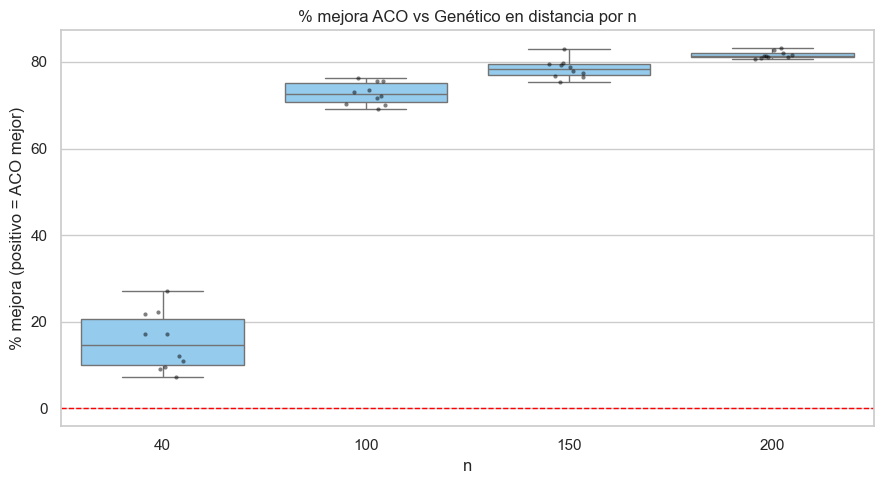

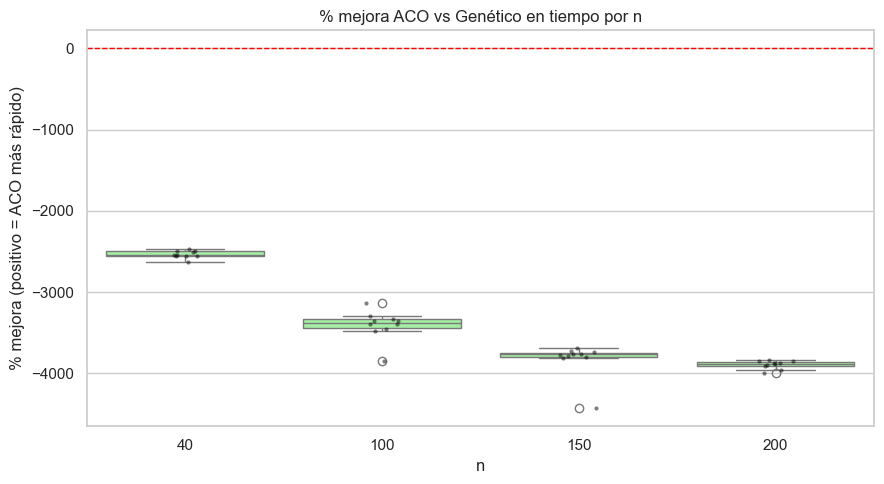

In [41]:
# Gráficos de mejoras por tamaño n
if 'mejora_dist_aco_vs_genetico_pct' in df_imp.columns:
    plt.figure(figsize=(9,5))
    if sns is not None:
        sns.boxplot(data=df_imp, x='n', y='mejora_dist_aco_vs_genetico_pct', color='#87cefa')
        sns.stripplot(data=df_imp, x='n', y='mejora_dist_aco_vs_genetico_pct', color='black', alpha=0.5, size=3)
    else:
        # Fallback matplotlib: boxplot por grupos de n
        labels = []
        series = []
        for nval, dsub in df_imp.groupby('n'):
            labels.append(nval)
            series.append(dsub['mejora_dist_aco_vs_genetico_pct'].dropna().values)
        plt.boxplot(series, labels=labels)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('% mejora ACO vs Genético en distancia por n')
    plt.ylabel('% mejora (positivo = ACO mejor)')
    plt.tight_layout()
    plt.savefig(DIR_OUT / 'mejora_dist_por_n.png', dpi=160)
    plt.show()

if 'mejora_tiempo_aco_vs_genetico_pct' in df_imp.columns:
    plt.figure(figsize=(9,5))
    if sns is not None:
        sns.boxplot(data=df_imp, x='n', y='mejora_tiempo_aco_vs_genetico_pct', color='#98fb98')
        sns.stripplot(data=df_imp, x='n', y='mejora_tiempo_aco_vs_genetico_pct', color='black', alpha=0.5, size=3)
    else:
        labels = []
        series = []
        for nval, dsub in df_imp.groupby('n'):
            labels.append(nval)
            series.append(dsub['mejora_tiempo_aco_vs_genetico_pct'].dropna().values)
        plt.boxplot(series, labels=labels)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('% mejora ACO vs Genético en tiempo por n')
    plt.ylabel('% mejora (positivo = ACO más rápido)')
    plt.tight_layout()
    plt.savefig(DIR_OUT / 'mejora_tiempo_por_n.png', dpi=160)
    plt.show()
